In [59]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [60]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [61]:
#Create variables for the stock we are analyzing and the amount of time

ticker = "ETH-USD"
inter = "5m" #crypto has to be every 5 minutes while stocks is 1m

In [62]:
df = pd.read_csv(
    Path(f"{ticker}_prices_{inter}.csv"),
    parse_dates=True,
    infer_datetime_format=True)

In [86]:
df = df.set_index(pd.DatetimeIndex(df['Datetime']), drop=True, append=False, inplace=False, verify_integrity=False)

In [64]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-01-06 05:00:00+00:00,2022-01-06 05:00:00+00:00,3458.27,3458.27,3453.92,3453.92,3453.92,0
2022-01-06 05:05:00+00:00,2022-01-06 05:05:00+00:00,3455.96,3464.21,3455.96,3464.21,3464.21,149757952
2022-01-06 05:10:00+00:00,2022-01-06 05:10:00+00:00,3470.80,3470.80,3468.58,3469.46,3469.46,28817408
2022-01-06 05:15:00+00:00,2022-01-06 05:15:00+00:00,3469.29,3473.64,3469.29,3473.64,3473.64,109973504
2022-01-06 05:20:00+00:00,2022-01-06 05:20:00+00:00,3474.18,3476.43,3474.18,3475.47,3475.47,79267840


In [65]:
#This function accepts the column number for the features (X) and the target (y). It chunks the data up with a rolling window of Xt - window to predict Xt. It returns two numpy arrays of X and y.

def window_data(df, window, feature_col_number, target_col_number):

    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [66]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 25

feature_column = 4
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:2]} \n")
print (f"y sample values:\n{y[:2]}")

X sample values:
[[3453.92 3464.21 3469.46 3473.64 3475.47 3478.62 3476.55 3477.42 3463.34
  3462.24 3465.89 3469.37 3460.92 3456.64 3456.82 3467.17 3468.97 3469.23
  3465.16 3457.81 3452.76 3446.52 3444.71 3449.86 3449.85]
 [3464.21 3469.46 3473.64 3475.47 3478.62 3476.55 3477.42 3463.34 3462.24
  3465.89 3469.37 3460.92 3456.64 3456.82 3467.17 3468.97 3469.23 3465.16
  3457.81 3452.76 3446.52 3444.71 3449.86 3449.85 3459.91]] 

y sample values:
[[3459.91]
 [3460.51]]


In [87]:
# Use 70% of the data for training and the remainder for testing
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [88]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [89]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.93135075]
  [0.95994997]
  [0.97454141]
  [0.98615898]
  [0.99124514]
  [1.        ]
  [0.9975739 ]
  [1.        ]
  [0.98279846]
  [0.97966053]
  [0.99007274]
  [1.        ]
  [0.97628492]
  [0.96407066]
  [0.96458434]
  [0.99412117]
  [0.99925801]
  [1.        ]
  [0.99403019]
  [0.97293496]
  [0.95844096]
  [0.94053154]
  [0.93533666]
  [0.95011767]
  [0.95008897]]

 [[0.95994997]
  [0.97454141]
  [0.98615898]
  [0.99124514]
  [1.        ]
  [0.9942468 ]
  [1.        ]
  [0.9607362 ]
  [0.97966053]
  [0.99007274]
  [1.        ]
  [0.97589502]
  [0.96407066]
  [0.96458434]
  [0.99412117]
  [0.99925801]
  [1.        ]
  [0.98838503]
  [0.97293496]
  [0.95844096]
  [0.94053154]
  [0.93533666]
  [0.95011767]
  [0.95008897]
  [0.97896217]]] 

X_test sample values:
[[[0.24838799]
  [0.24938855]
  [0.23312952]
  [0.23613118]
  [0.2356587 ]
  [0.24174541]
  [0.23600112]
  [0.21762409]
  [0.21734417]
  [0.21263728]
  [0.20151191]
  [0.21049779]
  [0.2124654 ]
  [0

In [90]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [91]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 25
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [92]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [93]:
# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 25, 25)            2700      
                                                                 
 dropout_9 (Dropout)         (None, 25, 25)            0         
                                                                 
 lstm_10 (LSTM)              (None, 25, 25)            5100      
                                                                 
 dropout_10 (Dropout)        (None, 25, 25)            0         
                                                                 
 lstm_11 (LSTM)              (None, 25)                5100      
                                                                 
 dropout_11 (Dropout)        (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [94]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=64, verbose=1)

Epoch 1/50
10/10 [==============================] - 9s 53ms/step - loss: 0.1804
Epoch 2/50
10/10 [==============================] - 1s 62ms/step - loss: 0.0451
Epoch 3/50
10/10 [==============================] - 1s 68ms/step - loss: 0.0142
Epoch 4/50
10/10 [==============================] - 1s 79ms/step - loss: 0.0261
Epoch 5/50
10/10 [==============================] - 1s 86ms/step - loss: 0.0130
Epoch 6/50
10/10 [==============================] - 1s 81ms/step - loss: 0.0115: 0s - los
Epoch 7/50
10/10 [==============================] - 1s 81ms/step - loss: 0.0113
Epoch 8/50
10/10 [==============================] - 1s 73ms/step - loss: 0.0116
Epoch 9/50
10/10 [==============================] - 1s 75ms/step - loss: 0.0096
Epoch 10/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0109
Epoch 11/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0104
Epoch 12/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0103
Epoch 13/50
10/10 [========

In [95]:
# Make some predictions
predicted = model.predict(X_test)

In [96]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [97]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Datetime,,
2022-01-08 15:50:00+00:00,3169.68,3174.119141
2022-01-08 15:55:00+00:00,3166.47,3172.550049
2022-01-08 16:00:00+00:00,3161.66,3171.158447
2022-01-08 16:05:00+00:00,3165.20,3169.901123
2022-01-08 16:10:00+00:00,3175.10,3168.770752


In [98]:
conditions = [
    (stocks['Real'] > stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] < stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] == stocks['Predicted'].shift(periods=-1))
     ]

values = ['-100', '100', '0']

stocks['Signal'] = np.select(conditions, values)

In [104]:
stocks.head(7)

,Real,Predicted,Signal
Datetime,,,
2022-01-08 15:50:00+00:00,3169.68,3174.119141,100
2022-01-08 15:55:00+00:00,3166.47,3172.550049,100
2022-01-08 16:00:00+00:00,3161.66,3171.158447,100
2022-01-08 16:05:00+00:00,3165.20,3169.901123,100
2022-01-08 16:10:00+00:00,3175.10,3168.770752,-100
2022-01-08 16:15:00+00:00,3176.24,3167.874756,-100
2022-01-08 16:20:00+00:00,3174.34,3167.253418,-100


<AxesSubplot:xlabel='Datetime'>

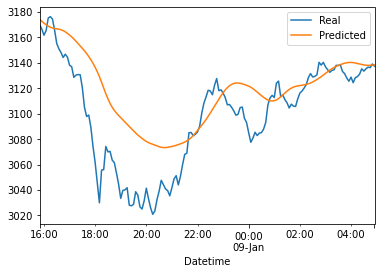

In [100]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

In [101]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 2s 10ms/step - loss: 0.0076


0.007615586742758751

In [102]:
stocks.to_csv("LSTM_signal.csv")

In [85]:
# # Visualize exit position relative to close price
# exit = stocks[stocks['Signal'] == -1.0]['Real'].hvplot.scatter(
#     color='yellow',
#     marker='v',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize entry position relative to close price
# entry = stocks[stocks['Signal'] == 1.0]['Real'].hvplot.scatter(
#     color='purple',
#     marker='^',
#     size=200,
#     legend=False,
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # Visualize close price for the investment
# security_close = stocks[['Real']].hvplot(
#     line_color='lightgray',
#     ylabel='Price in $',
#     width=1000,
#     height=400
# )

# # # Visualize moving averages
# # moving_avgs = stocks[['SMA50', 'SMA100']].hvplot(
# #     ylabel='Price in $',
# #     width=1000,
# #     height=400
# # )

# # Create the overlay plot
# entry_exit_plot = security_close * entry * exit

# # Show the plot with a title
# entry_exit_plot.opts(
#     title="Title"
# )